In [51]:

import qiskit; import numpy as np; import matplotlib.pyplot as plt; import random
%load_ext autoreload
%autoreload 2
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline


from qiskit import qpy

from qoop.evolution.environment_synthesis import MetadataSynthesis
from qoop.evolution.generator import by_num_rotations,by_num_rotations_and_cnot
from qoop.evolution.environment import EEnvironment
from qoop.evolution.crossover import onepoint
from qoop.evolution.mutate import bitflip_mutate_with_normalizer
from qoop.evolution.divider import by_num_cnot
from qoop.evolution.threshold import synthesis_threshold
from qoop.backend.constant import operations_with_rotations
from qoop.evolution.normalizer import by_num_cnot as normalizer_by_num_cnot
from qoop.evolution import divider
from qoop.backend.utilities import load_circuit



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test each component

In [5]:
from qoop.evolution import divider
from qoop.evolution import normalizer
print(dir(normalizer))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'by_depth', 'by_num_cnot', 'by_num_rotation_gate', 'divider_by_depth', 'divider_by_num_cnot', 'divider_by_num_rotation_gate', 'qiskit']


In [63]:

import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


def generate_wine(num_feature: int):
    
    # Load Wine Dataset
    wine = load_wine()
    X = wine.data
    y = wine.target

    # Lấy dữ liệu chỉ gồm lớp 0 và 1
    X = X[y != 2]
    y = y[y != 2]

    # Chia train-test
    Xw_train, Xw_test, yw_train, yw_test = train_test_split(X, y, test_size=0.2, random_state=42)


    scaler = StandardScaler()
    Xw_train = scaler.fit_transform(Xw_train)
    Xw_test = scaler.transform(Xw_test)

    # Áp dụng PCA
    pca = PCA(n_components= num_feature)
    Xw_train = pca.fit_transform(Xw_train)
    Xw_test = pca.transform(Xw_test)
    
    return Xw_train, yw_train, Xw_test, yw_test

In [35]:
Xw_train, yw_train, Xw_test, yw_test = generate_wine(5)

In [116]:
def train_qsvm_with_wine(quantum_circuit):
    backend = Aer.get_backend('statevector_simulator')
    quantum_kernel = QuantumKernel(feature_map=quantum_circuit, quantum_instance=backend)
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(Xw_train, yw_train)
    y_pred = qsvc.predict(Xw_test)
    accuracy = accuracy_score(yw_test, y_pred)

    return accuracy




In [7]:
# Define the metadata
env_metadata = MetadataSynthesis(
    num_qubits=4,            # Number of qubits
    num_cnot=3,              # Number of CNOT gates
    num_rx=1,                # Number of RX gates
    num_ry=1,                # Number of RY gates
    num_rz=5,                # Number of RZ gates
    depth=4,                 # Depth of the circuit
    num_circuit=4,           # Number of circuits in the population
    num_generation=10,       # Number of generations
    prob_mutate=0.01         # Mutation probability
)
circuit = by_num_rotations_and_cnot(env_metadata)
func = divider.by_num_rotation_gate(3)
qc1,qc2 = func(circuit)
print(qc1)

          ┌───┐      ┌──────────────┐
q_0: ─────┤ H ├──────┤ Rx(theta(2)) ├
          └───┘      └──────────────┘
q_1: ────────────────────────────────
     ┌──────────────┐                
q_2: ┤ Ry(theta(1)) ├────────────────
     ├──────────────┤                
q_3: ┤ Rz(theta(0)) ├────────────────
     └──────────────┘                


In [8]:
# Define the metadata
env_metadata = MetadataSynthesis(
    num_qubits=4,            # Number of qubits
    num_cnot=3,              # Number of CNOT gates
    num_rx=1,                # Number of RX gates
    num_ry=1,                # Number of RY gates
    num_rz=2,                # Number of RZ gates
    depth=4,                 # Depth of the circuit
    num_circuit=4,           # Number of circuits in the population
    num_generation=3,       # Number of generations
    prob_mutate=0.01         # Mutation probability
)

# Define the environment
env = EEnvironment(
    metadata=env_metadata,
    fitness_func=train_qsvm_with_wine,
    generator_func=by_num_rotations_and_cnot,  # Use the new generator function
    crossover_func=onepoint(
        divider.by_num_rotation_gate(int((env_metadata.num_qubits)/ 2)),
        normalizer.by_num_rotation_gate(env_metadata.num_qubits)
    ),
    mutate_func=bitflip_mutate_with_normalizer(operations_with_rotations, 
                                               normalizer_func=normalizer.by_num_rotation_gate(env_metadata.num_qubits)),
    threshold_func=synthesis_threshold
)

# Run the evolution process

env.evol(verbose=True, mode="noparallel")


len(env.best_circuit.parameters)

Step:   0%|          | 0/3 [00:00<?, ?it/s]

Initialize list of circuit ...
Start evol progress ...
Running at generation 1
     ┌───┐┌──────────────┐                               
q_0: ┤ H ├┤ Rz(theta(3)) ├────────────────────────────■──
     └───┘└──────────────┘                            │  
q_1: ────────────────────────────■────────────────────┼──
          ┌──────────────┐┌───┐  │  ┌──────────────┐  │  
q_2: ──■──┤ Rx(theta(0)) ├┤ H ├──┼──┤ Rz(theta(2)) ├──┼──
     ┌─┴─┐├──────────────┤└───┘┌─┴─┐└──────────────┘┌─┴─┐
q_3: ┤ X ├┤ Ry(theta(1)) ├─────┤ X ├────────────────┤ X ├
     └───┘└──────────────┘     └───┘                └───┘
parameter:  4
                               ┌──────────────┐                          
q_0: ───────────────────────■──┤ Rz(theta(3)) ├──────────────────────────
                            │  └──────────────┘                     ┌───┐
q_1: ──────────────────■────┼────────────────────────────────────■──┤ H ├
          ┌───┐      ┌─┴─┐  │  ┌──────────────┐┌──────────────┐┌─┴─┐└───┘
q_2: ─────┤ H ├

Step:  67%|██████▋   | 2/3 [00:01<00:00,  1.03it/s]

[0.8846 0.8846 0.6154 0.7692]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 2
     ┌───┐┌──────────────┐                               
q_0: ┤ H ├┤ Rz(theta[3]) ├────────────────────────────■──
     └───┘└──────────────┘                            │  
q_1: ────────────────────────────■────────────────────┼──
          ┌──────────────┐┌───┐  │  ┌──────────────┐  │  
q_2: ──■──┤ Rx(theta[0]) ├┤ H ├──┼──┤ Rz(theta[2]) ├──┼──
     ┌─┴─┐├──────────────┤└───┘┌─┴─┐└──────────────┘┌─┴─┐
q_3: ┤ X ├┤ Ry(theta[1]) ├─────┤ X ├────────────────┤ X ├
     └───┘└──────────────┘     └───┘                └───┘
parameter:  4
                               ┌──────────────┐                          
q_0: ───────────────────────■──┤ Rz(theta[3]) ├──────────────────────────
                            │  └──────────────┘                     ┌───┐
q_1: ──────────────────■────┼────────────────────────────────────■──┤ H ├
          ┌───┐      ┌─┴─┐  │

Step: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

[0.8846 0.8846 0.7692 0.9231]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 3
                                    ┌───┐      ┌──────────────┐     
q_0: ───────────────────────■───────┤ H ├──────┤ Rz(theta[3]) ├─────
                            │       └───┘      └──────────────┘     
q_1: ──────────────────■────┼────────────────────────────────────■──
     ┌──────────────┐┌─┴─┐  │  ┌──────────────┐┌──────────────┐  │  
q_2: ┤ Rz(theta[0]) ├┤ X ├──┼──┤ Rx(theta[1]) ├┤ Rz(theta[2]) ├──┼──
     └────┬───┬─────┘├───┤┌─┴─┐└──────────────┘└──────────────┘┌─┴─┐
q_3: ─────┤ H ├──────┤ H ├┤ X ├────────────────────────────────┤ X ├
          └───┘      └───┘└───┘                                └───┘
parameter:  4
     ┌───┐┌──────────────┐                               
q_0: ┤ H ├┤ Rz(theta[3]) ├────────────────────────────■──
     └───┘└──────────────┘                            │  
q_1: ────────────────────────────■──────────────────

Step: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

[0.9231 0.8846 0.9231 0.6923]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
End evol progress, best score ever: 0.9230769230769231


4

In [9]:
test = env.best_circuit
print(test)

                                    ┌───┐      ┌──────────────┐     
q_0: ───────────────────────■───────┤ H ├──────┤ Rz(theta[3]) ├─────
                            │       └───┘      └──────────────┘     
q_1: ──────────────────■────┼────────────────────────────────────■──
     ┌──────────────┐┌─┴─┐  │  ┌──────────────┐┌──────────────┐  │  
q_2: ┤ Rz(theta[0]) ├┤ X ├──┼──┤ Rx(theta[1]) ├┤ Rz(theta[2]) ├──┼──
     └────┬───┬─────┘├───┤┌─┴─┐└──────────────┘└──────────────┘┌─┴─┐
q_3: ─────┤ H ├──────┤ H ├┤ X ├────────────────────────────────┤ X ├
          └───┘      └───┘└───┘                                └───┘


In [10]:
circuit1=load_circuit('4qubits_train_qsvm_with_wine_2024-12-28/best_circuit')
circuit1.draw(style="mql")

┌──────────────┐          ┌──────────────┐                     ┌───┐
q_0: ┤ Rx(theta[0]) ├───────■──┤ Rz(theta[2]) ├─────────────────────┤ X ├
     └──────────────┘       │  └──────────────┘                     └─┬─┘
q_1: ───────■──────────■────┼────────────────────■────────────────────┼──
            │        ┌─┴─┐  │  ┌──────────────┐  │                    │  
q_2: ───────┼────────┤ X ├──┼──┤ Ry(theta[3]) ├──┼────────────────────┼──
          ┌─┴─┐      ├───┤┌─┴─┐└──────────────┘┌─┴─┐┌──────────────┐  │  
q_3: ─────┤ X ├──────┤ H ├┤ X ├────────────────┤ X ├┤ Rz(theta[1]) ├──■──
          └───┘      └───┘└───┘                └───┘└──────────────┘

In [11]:
train_qsvm_with_wine(circuit1)

parameter:  4


0.9230769230769231

In [68]:
from TestGAGermanCreditData import X_train as Xcredit_train
from TestGAGermanCreditData import X_test as Xcredit_test
from TestGAGermanCreditData import y_train as yc_train
from TestGAGermanCreditData import y_test as yc_test


def generate_credit(num_feature: int):


    scaler = StandardScaler()
    Xc_train = scaler.fit_transform(Xcredit_train)
    Xc_test = scaler.transform(Xcredit_test)

    # Áp dụng PCA
    pca = PCA(n_components= num_feature)
    Xc_train = pca.fit_transform(Xc_train)
    Xc_test = pca.transform(Xc_test)
    
    return Xc_train, yc_train, Xc_test, yc_test

In [69]:
def train_qsvm_with_credit(quantum_circuit):
    backend = Aer.get_backend('statevector_simulator')
    quantum_kernel = QuantumKernel(feature_map=quantum_circuit, quantum_instance=backend)
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(Xc_train, yc_train)
    y_pred = qsvc.predict(Xc_test)
    accuracy = accuracy_score(yc_test, y_pred)

    return accuracy

In [152]:
def train_svm(feature_num: int, generate_dataset):


    Xsvm_train, ysvm_train, Xsvm_test, ysvm_test = generate_dataset(feature_num)
    svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

    # Train the SVM
    svm_pipeline.fit(Xsvm_train, ysvm_train)

    # Test the SVM
    accuracy = svm_pipeline.score(Xsvm_test, ysvm_test)
    return accuracy

# AUTOMATIC SETUP


In [175]:
def auto_run(num_qubits: int):
    
    
    Xw_train, yw_train, Xw_test, yw_test = generate_wine(i)
    
    def train_qsvm_with_wine(quantum_circuit):
        backend = Aer.get_backend('statevector_simulator')
        quantum_kernel = QuantumKernel(feature_map=quantum_circuit, quantum_instance=backend)
        qsvc = QSVC(quantum_kernel=quantum_kernel)
        qsvc.fit(Xw_train, yw_train)
        y_pred = qsvc.predict(Xw_test)
        accuracy = accuracy_score(yw_test, y_pred)

        return accuracy
    
    
    # GA
    num_cnot = num_qubits + 1

    num_rx = random.randint(0, num_qubits)
    num_ry = random.randint(0, num_qubits - num_rx)
    num_rz = num_qubits - (num_rx + num_ry)  # Ensure the sum matches num_qubits
        
        # Define the metadata
        
    env_metadata = MetadataSynthesis(
        num_qubits=num_qubits,            # Number of qubits
        num_cnot=num_cnot,              # Number of CNOT gates
        num_rx=num_rx,                # Number of RX gates
        num_ry=num_ry,                # Number of RY gates
        num_rz=num_rz,                # Number of RZ gates
        depth=4,                 # Depth of the circuit
        num_circuit=4,           # Number of circuits in the population
        num_generation=10,       # Number of generations
        prob_mutate=0.01         # Mutation probability
    )

    # Define the environment
    env = EEnvironment(
        metadata=env_metadata,
        fitness_func=train_qsvm_with_wine,
        generator_func=by_num_rotations_and_cnot,  # Use the new generator function
        crossover_func=onepoint(
            divider.by_num_rotation_gate(int((env_metadata.num_qubits)/ 2)),
            normalizer.by_num_rotation_gate(env_metadata.num_qubits)
        ),
        mutate_func=bitflip_mutate_with_normalizer(operations_with_rotations, 
                                                normalizer_func=normalizer.by_num_rotation_gate(env_metadata.num_qubits)),
        threshold_func=synthesis_threshold
    )

    # Run the evolution process

    env.evol(verbose=True, mode="noparallel")
    env.plot()
    
    
    

Initialize list of circuit ...
Start evol progress ...
Running at generation 1
          ┌───┐                                          
q_0: ─────┤ X ├────────■─────────────────────────────────
          └─┬─┘        │  ┌───┐          ┌──────────────┐
q_1: ───────■──────────┼──┤ H ├──■────■──┤ Rz(theta(1)) ├
     ┌──────────────┐┌─┴─┐└───┘┌─┴─┐┌─┴─┐├──────────────┤
q_2: ┤ Rz(theta(0)) ├┤ X ├─────┤ X ├┤ X ├┤ Rz(theta(2)) ├
     └──────────────┘└───┘     └───┘└───┘└──────────────┘
     ┌──────────────┐┌───┐          ┌───┐      ┌───┐                     
q_0: ┤ Rz(theta(0)) ├┤ X ├──────────┤ X ├──────┤ H ├──■──────────────────
     └──────────────┘└─┬─┘          └─┬─┘      └───┘┌─┴─┐┌──────────────┐
q_1: ──────────────────■────■─────────■─────────────┤ X ├┤ Rz(theta(2)) ├
                          ┌─┴─┐┌──────────────┐     └───┘└──────────────┘
q_2: ─────────────────────┤ X ├┤ Rz(theta(1)) ├──────────────────────────
                          └───┘└──────────────┘                        

[0.5769 0.5    0.5    0.5769]
Saving circuit ...
combined_qc1:  3
combined_qc2:  3
Số circuit 4
Saving circuit ...
Running at generation 2
          ┌───┐                                          
q_0: ─────┤ X ├────────■─────────────────────────────────
          └─┬─┘        │  ┌───┐          ┌──────────────┐
q_1: ───────■──────────┼──┤ H ├──■────■──┤ Rz(theta[1]) ├
     ┌──────────────┐┌─┴─┐└───┘┌─┴─┐┌─┴─┐├──────────────┤
q_2: ┤ Rz(theta[0]) ├┤ X ├─────┤ X ├┤ X ├┤ Rz(theta[2]) ├
     └──────────────┘└───┘     └───┘└───┘└──────────────┘
          ┌───┐      ┌───┐┌──────────────┐                     ┌───┐
q_0: ─────┤ H ├──────┤ X ├┤ Rz(theta[1]) ├─────────────────────┤ X ├
          └───┘      └─┬─┘└────┬───┬─────┘┌───┐┌──────────────┐└─┬─┘
q_1: ──────────────────┼───────┤ X ├──────┤ X ├┤ Rz(theta[2]) ├──┼──
     ┌──────────────┐  │       └─┬─┘      └─┬─┘└──────────────┘  │  
q_2: ┤ Rz(theta[0]) ├──■─────────■──────────■────────────────────■──
     └──────────────┘                    

[0.5769 0.5769 0.5769 0.5769]
Saving circuit ...
combined_qc1:  3
combined_qc2:  3
Số circuit 4
Saving circuit ...
Running at generation 3
          ┌───┐                                          
q_0: ─────┤ X ├────────■─────────────────────────────────
          └─┬─┘        │  ┌───┐          ┌──────────────┐
q_1: ───────■──────────┼──┤ H ├──■────■──┤ Rz(theta[1]) ├
     ┌──────────────┐┌─┴─┐└───┘┌─┴─┐┌─┴─┐├──────────────┤
q_2: ┤ Rz(theta[0]) ├┤ X ├─────┤ X ├┤ X ├┤ Rz(theta[2]) ├
     └──────────────┘└───┘     └───┘└───┘└──────────────┘
          ┌───┐      ┌───┐┌──────────────┐                     ┌───┐
q_0: ─────┤ H ├──────┤ X ├┤ Rz(theta[1]) ├─────────────────────┤ X ├
          └───┘      └─┬─┘└────┬───┬─────┘┌───┐┌──────────────┐└─┬─┘
q_1: ──────────────────┼───────┤ X ├──────┤ X ├┤ Rz(theta[2]) ├──┼──
     ┌──────────────┐  │       └─┬─┘      └─┬─┘└──────────────┘  │  
q_2: ┤ Rz(theta[0]) ├──■─────────■──────────■────────────────────■──
     └──────────────┘                    

[0.5769 0.5769 0.5769 0.5769]
Saving circuit ...
combined_qc1:  3
combined_qc2:  3
Số circuit 4
Saving circuit ...
Running at generation 4
          ┌───┐                                          
q_0: ─────┤ X ├────────■─────────────────────────────────
          └─┬─┘        │  ┌───┐          ┌──────────────┐
q_1: ───────■──────────┼──┤ H ├──■────■──┤ Rz(theta[1]) ├
     ┌──────────────┐┌─┴─┐└───┘┌─┴─┐┌─┴─┐├──────────────┤
q_2: ┤ Rz(theta[0]) ├┤ X ├─────┤ X ├┤ X ├┤ Rz(theta[2]) ├
     └──────────────┘└───┘     └───┘└───┘└──────────────┘


Step:  50%|█████     | 5/10 [03:02<03:02, 36.50s/it]


          ┌───┐      ┌───┐┌──────────────┐                     ┌───┐
q_0: ─────┤ H ├──────┤ X ├┤ Rz(theta[1]) ├─────────────────────┤ X ├
          └───┘      └─┬─┘└────┬───┬─────┘┌───┐┌──────────────┐└─┬─┘
q_1: ──────────────────┼───────┤ X ├──────┤ X ├┤ Rz(theta[2]) ├──┼──
     ┌──────────────┐  │       └─┬─┘      └─┬─┘└──────────────┘  │  
q_2: ┤ Rz(theta[0]) ├──■─────────■──────────■────────────────────■──
     └──────────────┘                                               
          ┌───┐      ┌───┐┌───┐┌──────────────┐                     ┌───┐
q_0: ─────┤ X ├──────┤ H ├┤ X ├┤ Rz(theta[1]) ├─────────────────────┤ X ├
          └─┬─┘      └───┘└─┬─┘└────┬───┬─────┘┌───┐┌──────────────┐└─┬─┘
q_1: ───────■───────────────┼───────┤ X ├──────┤ X ├┤ Rz(theta[2]) ├──┼──
     ┌──────────────┐       │       └─┬─┘      └─┬─┘└──────────────┘  │  
q_2: ┤ Rz(theta[0]) ├───────■─────────■──────────■────────────────────■──
     └──────────────┘                                                    

[0.5769 0.5769 0.5769 0.5769]
Saving circuit ...
combined_qc1:  3
combined_qc2:  3
Số circuit 4
Saving circuit ...
Running at generation 5
          ┌───┐                                          
q_0: ─────┤ X ├────────■─────────────────────────────────
          └─┬─┘        │  ┌───┐          ┌──────────────┐
q_1: ───────■──────────┼──┤ H ├──■────■──┤ Rz(theta[1]) ├
     ┌──────────────┐┌─┴─┐└───┘┌─┴─┐┌─┴─┐├──────────────┤
q_2: ┤ Rz(theta[0]) ├┤ X ├─────┤ X ├┤ X ├┤ Rz(theta[2]) ├
     └──────────────┘└───┘     └───┘└───┘└──────────────┘
          ┌───┐      ┌───┐┌──────────────┐                     ┌───┐
q_0: ─────┤ H ├──────┤ X ├┤ Rz(theta[1]) ├─────────────────────┤ X ├
          └───┘      └─┬─┘└────┬───┬─────┘┌───┐┌──────────────┐└─┬─┘
q_1: ──────────────────┼───────┤ X ├──────┤ X ├┤ Rz(theta[2]) ├──┼──
     ┌──────────────┐  │       └─┬─┘      └─┬─┘└──────────────┘  │  
q_2: ┤ Rz(theta[0]) ├──■─────────■──────────■────────────────────■──
     └──────────────┘                    

[0.5769 0.5769 0.5769 0.5769]
Saving circuit ...
combined_qc1:  3
combined_qc2:  3
Số circuit 4
Saving circuit ...
Running at generation 6
          ┌───┐                                          
q_0: ─────┤ X ├────────■─────────────────────────────────
          └─┬─┘        │  ┌───┐          ┌──────────────┐
q_1: ───────■──────────┼──┤ H ├──■────■──┤ Rz(theta[1]) ├
     ┌──────────────┐┌─┴─┐└───┘┌─┴─┐┌─┴─┐├──────────────┤
q_2: ┤ Rz(theta[0]) ├┤ X ├─────┤ X ├┤ X ├┤ Rz(theta[2]) ├
     └──────────────┘└───┘     └───┘└───┘└──────────────┘
          ┌───┐      ┌───┐┌──────────────┐                     ┌───┐
q_0: ─────┤ H ├──────┤ X ├┤ Rz(theta[1]) ├─────────────────────┤ X ├
          └───┘      └─┬─┘└────┬───┬─────┘┌───┐┌──────────────┐└─┬─┘
q_1: ──────────────────┼───────┤ X ├──────┤ X ├┤ Rz(theta[2]) ├──┼──
     ┌──────────────┐  │       └─┬─┘      └─┬─┘└──────────────┘  │  
q_2: ┤ Rz(theta[0]) ├──■─────────■──────────■────────────────────■──
     └──────────────┘                    

[0.5769 0.5769 0.5769 0.5769]
Saving circuit ...
combined_qc1:  3
combined_qc2:  3
Số circuit 4
Saving circuit ...
Running at generation 7
          ┌───┐                                          
q_0: ─────┤ X ├────────■─────────────────────────────────
          └─┬─┘        │  ┌───┐          ┌──────────────┐
q_1: ───────■──────────┼──┤ H ├──■────■──┤ Rz(theta[1]) ├
     ┌──────────────┐┌─┴─┐└───┘┌─┴─┐┌─┴─┐├──────────────┤
q_2: ┤ Rz(theta[0]) ├┤ X ├─────┤ X ├┤ X ├┤ Rz(theta[2]) ├
     └──────────────┘└───┘     └───┘└───┘└──────────────┘
          ┌───┐      ┌───┐┌──────────────┐                     ┌───┐
q_0: ─────┤ H ├──────┤ X ├┤ Rz(theta[1]) ├─────────────────────┤ X ├
          └───┘      └─┬─┘└────┬───┬─────┘┌───┐┌──────────────┐└─┬─┘
q_1: ──────────────────┼───────┤ X ├──────┤ X ├┤ Rz(theta[2]) ├──┼──
     ┌──────────────┐  │       └─┬─┘      └─┬─┘└──────────────┘  │  
q_2: ┤ Rz(theta[0]) ├──■─────────■──────────■────────────────────■──
     └──────────────┘                    

[0.5769 0.5769 0.5769 0.5769]
Saving circuit ...
combined_qc1:  3
combined_qc2:  3
Số circuit 4
Saving circuit ...
Running at generation 8
          ┌───┐                                          
q_0: ─────┤ X ├────────■─────────────────────────────────
          └─┬─┘        │  ┌───┐          ┌──────────────┐
q_1: ───────■──────────┼──┤ H ├──■────■──┤ Rz(theta[1]) ├
     ┌──────────────┐┌─┴─┐└───┘┌─┴─┐┌─┴─┐├──────────────┤
q_2: ┤ Rz(theta[0]) ├┤ X ├─────┤ X ├┤ X ├┤ Rz(theta[2]) ├
     └──────────────┘└───┘     └───┘└───┘└──────────────┘
          ┌───┐      ┌───┐┌──────────────┐                     ┌───┐
q_0: ─────┤ H ├──────┤ X ├┤ Rz(theta[1]) ├─────────────────────┤ X ├
          └───┘      └─┬─┘└────┬───┬─────┘┌───┐┌──────────────┐└─┬─┘
q_1: ──────────────────┼───────┤ X ├──────┤ X ├┤ Rz(theta[2]) ├──┼──
     ┌──────────────┐  │       └─┬─┘      └─┬─┘└──────────────┘  │  
q_2: ┤ Rz(theta[0]) ├──■─────────■──────────■────────────────────■──
     └──────────────┘                    

[0.5769 0.5769 0.5769 0.5769]
Saving circuit ...
combined_qc1:  3
combined_qc2:  3
Số circuit 4
Saving circuit ...
Running at generation 9
          ┌───┐                                          
q_0: ─────┤ X ├────────■─────────────────────────────────
          └─┬─┘        │  ┌───┐          ┌──────────────┐
q_1: ───────■──────────┼──┤ H ├──■────■──┤ Rz(theta[1]) ├
     ┌──────────────┐┌─┴─┐└───┘┌─┴─┐┌─┴─┐├──────────────┤
q_2: ┤ Rz(theta[0]) ├┤ X ├─────┤ X ├┤ X ├┤ Rz(theta[2]) ├
     └──────────────┘└───┘     └───┘└───┘└──────────────┘
          ┌───┐      ┌───┐┌──────────────┐                     ┌───┐
q_0: ─────┤ H ├──────┤ X ├┤ Rz(theta[1]) ├─────────────────────┤ X ├
          └───┘      └─┬─┘└────┬───┬─────┘┌───┐┌──────────────┐└─┬─┘
q_1: ──────────────────┼───────┤ X ├──────┤ X ├┤ Rz(theta[2]) ├──┼──
     ┌──────────────┐  │       └─┬─┘      └─┬─┘└──────────────┘  │  
q_2: ┤ Rz(theta[0]) ├──■─────────■──────────■────────────────────■──
     └──────────────┘                    

[0.5769 0.5769 0.5769 0.5769]
Saving circuit ...
combined_qc1:  3
combined_qc2:  3
Số circuit 4
Saving circuit ...
Running at generation 10
          ┌───┐                                          
q_0: ─────┤ X ├────────■─────────────────────────────────
          └─┬─┘        │  ┌───┐          ┌──────────────┐
q_1: ───────■──────────┼──┤ H ├──■────■──┤ Rz(theta[1]) ├
     ┌──────────────┐┌─┴─┐└───┘┌─┴─┐┌─┴─┐├──────────────┤
q_2: ┤ Rz(theta[0]) ├┤ X ├─────┤ X ├┤ X ├┤ Rz(theta[2]) ├
     └──────────────┘└───┘     └───┘└───┘└──────────────┘
          ┌───┐      ┌───┐┌──────────────┐                     ┌───┐
q_0: ─────┤ H ├──────┤ X ├┤ Rz(theta[1]) ├─────────────────────┤ X ├
          └───┘      └─┬─┘└────┬───┬─────┘┌───┐┌──────────────┐└─┬─┘
q_1: ──────────────────┼───────┤ X ├──────┤ X ├┤ Rz(theta[2]) ├──┼──
     ┌──────────────┐  │       └─┬─┘      └─┬─┘└──────────────┘  │  
q_2: ┤ Rz(theta[0]) ├──■─────────■──────────■────────────────────■──
     └──────────────┘                   

Step: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]

[0.5769 0.5769 0.5769 0.5769]
Saving circuit ...
combined_qc1:  3
combined_qc2:  3
Số circuit 4
Saving circuit ...
End evol progress, best score ever: 0.5769230769230769


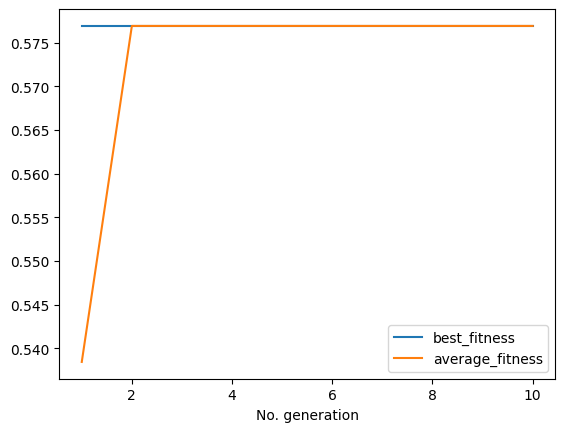

Initialize list of circuit ...
Start evol progress ...
Running at generation 1
     ┌───┐┌──────────────┐                          ┌───┐      ┌───┐»
q_0: ┤ X ├┤ Rx(theta(0)) ├────────────■─────────────┤ X ├──────┤ X ├»
     └─┬─┘└──────────────┘┌───┐     ┌─┴─┐           └─┬─┘      └─┬─┘»
q_1: ──┼──────────────────┤ X ├─────┤ X ├─────────────┼──────────■──»
       │       ┌───┐      └─┬─┘     └───┘             │             »
q_2: ──┼───────┤ H ├────────┼─────────────────────────■─────────────»
       │       ├───┤        │  ┌──────────────┐┌──────────────┐     »
q_3: ──■───────┤ H ├────────■──┤ Ry(theta(1)) ├┤ Rx(theta(2)) ├─────»
               └───┘           └──────────────┘└──────────────┘     »
«     ┌──────────────┐
«q_0: ┤ Rx(theta(3)) ├
«     └──────────────┘
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
«                     
     ┌──────────────┐┌──────────────┐┌───┐┌──────────────┐┌───┐               »
q_0:

[0.7308 0.8462 0.9231 0.8846]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 2
          ┌───┐                                               ┌───┐      »
q_0: ─────┤ X ├───────────────────────────────────────■───────┤ H ├──────»
          └─┬─┘                     ┌──────────────┐┌─┴─┐┌────┴───┴─────┐»
q_1: ──■────┼────────────────────■──┤ Rx(theta[1]) ├┤ X ├┤ Ry(theta[3]) ├»
     ┌─┴─┐  │  ┌──────────────┐┌─┴─┐└────┬───┬─────┘└───┘└──────────────┘»
q_2: ┤ X ├──┼──┤ Rx(theta[0]) ├┤ X ├─────┤ X ├───────────────────────────»
     └───┘  │  └──────────────┘└───┘     └─┬─┘                           »
q_3: ───────■──────────────────────────────■─────────────────────────────»
                                                                         »
«     ┌──────────────┐
«q_0: ┤ Rx(theta[2]) ├
«     └──────────────┘
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
« 

[0.9231 0.8846 0.9231 0.8846]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 3
          ┌───┐                                               ┌───┐      »
q_0: ─────┤ X ├───────────────────────────────────────■───────┤ H ├──────»
          └─┬─┘                     ┌──────────────┐┌─┴─┐┌────┴───┴─────┐»
q_1: ──■────┼────────────────────■──┤ Rx(theta[1]) ├┤ X ├┤ Ry(theta[3]) ├»
     ┌─┴─┐  │  ┌──────────────┐┌─┴─┐└────┬───┬─────┘└───┘└──────────────┘»
q_2: ┤ X ├──┼──┤ Rx(theta[0]) ├┤ X ├─────┤ X ├───────────────────────────»
     └───┘  │  └──────────────┘└───┘     └─┬─┘                           »
q_3: ───────■──────────────────────────────■─────────────────────────────»
                                                                         »
«     ┌──────────────┐
«q_0: ┤ Rx(theta[2]) ├
«     └──────────────┘
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
« 

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 4
          ┌───┐                                               ┌───┐      »
q_0: ─────┤ X ├───────────────────────────────────────■───────┤ H ├──────»
          └─┬─┘                     ┌──────────────┐┌─┴─┐┌────┴───┴─────┐»
q_1: ──■────┼────────────────────■──┤ Rx(theta[1]) ├┤ X ├┤ Ry(theta[3]) ├»
     ┌─┴─┐  │  ┌──────────────┐┌─┴─┐└────┬───┬─────┘└───┘└──────────────┘»
q_2: ┤ X ├──┼──┤ Rx(theta[0]) ├┤ X ├─────┤ X ├───────────────────────────»
     └───┘  │  └──────────────┘└───┘     └─┬─┘                           »
q_3: ───────■──────────────────────────────■─────────────────────────────»
                                                                         »
«     ┌──────────────┐
«q_0: ┤ Rx(theta[2]) ├
«     └──────────────┘
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
« 

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 5
          ┌───┐                                               ┌───┐      »
q_0: ─────┤ X ├───────────────────────────────────────■───────┤ H ├──────»
          └─┬─┘                     ┌──────────────┐┌─┴─┐┌────┴───┴─────┐»
q_1: ──■────┼────────────────────■──┤ Rx(theta[1]) ├┤ X ├┤ Ry(theta[3]) ├»
     ┌─┴─┐  │  ┌──────────────┐┌─┴─┐└────┬───┬─────┘└───┘└──────────────┘»
q_2: ┤ X ├──┼──┤ Rx(theta[0]) ├┤ X ├─────┤ X ├───────────────────────────»
     └───┘  │  └──────────────┘└───┘     └─┬─┘                           »
q_3: ───────■──────────────────────────────■─────────────────────────────»
                                                                         »
«     ┌──────────────┐
«q_0: ┤ Rx(theta[2]) ├
«     └──────────────┘
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
« 

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 6
          ┌───┐                                               ┌───┐      »
q_0: ─────┤ X ├───────────────────────────────────────■───────┤ H ├──────»
          └─┬─┘                     ┌──────────────┐┌─┴─┐┌────┴───┴─────┐»
q_1: ──■────┼────────────────────■──┤ Rx(theta[1]) ├┤ X ├┤ Ry(theta[3]) ├»
     ┌─┴─┐  │  ┌──────────────┐┌─┴─┐└────┬───┬─────┘└───┘└──────────────┘»
q_2: ┤ X ├──┼──┤ Rx(theta[0]) ├┤ X ├─────┤ X ├───────────────────────────»
     └───┘  │  └──────────────┘└───┘     └─┬─┘                           »
q_3: ───────■──────────────────────────────■─────────────────────────────»
                                                                         »
«     ┌──────────────┐
«q_0: ┤ Rx(theta[2]) ├
«     └──────────────┘
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
« 

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 7
          ┌───┐                                               ┌───┐      »
q_0: ─────┤ X ├───────────────────────────────────────■───────┤ H ├──────»
          └─┬─┘                     ┌──────────────┐┌─┴─┐┌────┴───┴─────┐»
q_1: ──■────┼────────────────────■──┤ Rx(theta[1]) ├┤ X ├┤ Ry(theta[3]) ├»
     ┌─┴─┐  │  ┌──────────────┐┌─┴─┐└────┬───┬─────┘└───┘└──────────────┘»
q_2: ┤ X ├──┼──┤ Rx(theta[0]) ├┤ X ├─────┤ X ├───────────────────────────»
     └───┘  │  └──────────────┘└───┘     └─┬─┘                           »
q_3: ───────■──────────────────────────────■─────────────────────────────»
                                                                         »
«     ┌──────────────┐
«q_0: ┤ Rx(theta[2]) ├
«     └──────────────┘
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
« 

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 8
          ┌───┐                                               ┌───┐      »
q_0: ─────┤ X ├───────────────────────────────────────■───────┤ H ├──────»
          └─┬─┘                     ┌──────────────┐┌─┴─┐┌────┴───┴─────┐»
q_1: ──■────┼────────────────────■──┤ Rx(theta[1]) ├┤ X ├┤ Ry(theta[3]) ├»
     ┌─┴─┐  │  ┌──────────────┐┌─┴─┐└────┬───┬─────┘└───┘└──────────────┘»
q_2: ┤ X ├──┼──┤ Rx(theta[0]) ├┤ X ├─────┤ X ├───────────────────────────»
     └───┘  │  └──────────────┘└───┘     └─┬─┘                           »
q_3: ───────■──────────────────────────────■─────────────────────────────»
                                                                         »
«     ┌──────────────┐
«q_0: ┤ Rx(theta[2]) ├
«     └──────────────┘
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
« 

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 9
          ┌───┐                                               ┌───┐      »
q_0: ─────┤ X ├───────────────────────────────────────■───────┤ H ├──────»
          └─┬─┘                     ┌──────────────┐┌─┴─┐┌────┴───┴─────┐»
q_1: ──■────┼────────────────────■──┤ Rx(theta[1]) ├┤ X ├┤ Ry(theta[3]) ├»
     ┌─┴─┐  │  ┌──────────────┐┌─┴─┐└────┬───┬─────┘└───┘└──────────────┘»
q_2: ┤ X ├──┼──┤ Rx(theta[0]) ├┤ X ├─────┤ X ├───────────────────────────»
     └───┘  │  └──────────────┘└───┘     └─┬─┘                           »
q_3: ───────■──────────────────────────────■─────────────────────────────»
                                                                         »
«     ┌──────────────┐
«q_0: ┤ Rx(theta[2]) ├
«     └──────────────┘
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
« 

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
Running at generation 10
          ┌───┐                                               ┌───┐      »
q_0: ─────┤ X ├───────────────────────────────────────■───────┤ H ├──────»
          └─┬─┘                     ┌──────────────┐┌─┴─┐┌────┴───┴─────┐»
q_1: ──■────┼────────────────────■──┤ Rx(theta[1]) ├┤ X ├┤ Ry(theta[3]) ├»
     ┌─┴─┐  │  ┌──────────────┐┌─┴─┐└────┬───┬─────┘└───┘└──────────────┘»
q_2: ┤ X ├──┼──┤ Rx(theta[0]) ├┤ X ├─────┤ X ├───────────────────────────»
     └───┘  │  └──────────────┘└───┘     └─┬─┘                           »
q_3: ───────■──────────────────────────────■─────────────────────────────»
                                                                         »
«     ┌──────────────┐
«q_0: ┤ Rx(theta[2]) ├
«     └──────────────┘
«q_1: ────────────────
«                     
«q_2: ────────────────
«                     
«q_3: ────────────────
«

Step: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  4
combined_qc2:  4
Số circuit 4
Saving circuit ...
End evol progress, best score ever: 0.9230769230769231


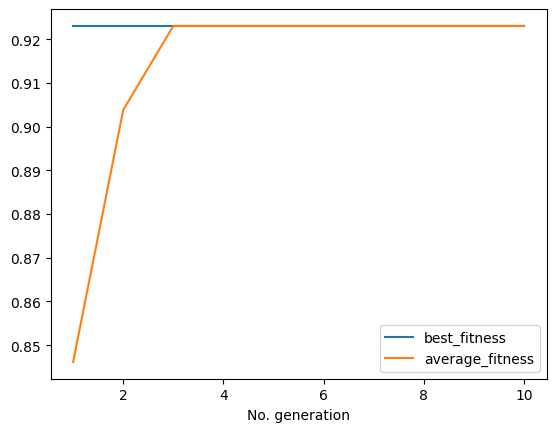

Initialize list of circuit ...
Start evol progress ...
Running at generation 1
     ┌──────────────┐                               ┌──────────────┐»
q_0: ┤ Rx(theta(0)) ├──■─────────────────────────■──┤ Rx(theta(1)) ├»
     └──────────────┘  │                         │  └──────────────┘»
q_1: ──────────────────┼────■────────────────────┼──────────────────»
                     ┌─┴─┐  │  ┌──────────────┐  │                  »
q_2: ────────────────┤ X ├──┼──┤ Rx(theta(4)) ├──┼──────────────────»
                     └───┘  │  └──────────────┘  │       ┌───┐      »
q_3: ───────■───────────────┼────────────────────┼───────┤ X ├──────»
          ┌─┴─┐      ┌───┐┌─┴─┐     ┌───┐      ┌─┴─┐     └─┬─┘      »
q_4: ─────┤ X ├──────┤ H ├┤ X ├─────┤ H ├──────┤ X ├───────■────────»
          └───┘      └───┘└───┘     └───┘      └───┘                »
«     ┌──────────────┐┌───┐┌──────────────┐
«q_0: ┤ Rx(theta(2)) ├┤ H ├┤ Rx(theta(3)) ├
«     └────┬───┬─────┘└───┘└──────────────┘
«q_1: ─────┤ X ├───

[0.7692 0.9231 0.6923 0.6923]
Saving circuit ...
combined_qc1:  5
combined_qc2:  5
Số circuit 4
Saving circuit ...
Running at generation 2
     ┌──────────────┐                                                         »
q_0: ┤ Rx(theta[3]) ├─────────────────────────────────────────────────────────»
     └────┬───┬─────┘                                               ┌───┐     »
q_1: ─────┤ X ├─────────────────────────────────────────────■───────┤ X ├──■──»
          └─┬─┘      ┌──────────────┐┌──────────────┐┌───┐  │  ┌───┐└─┬─┘  │  »
q_2: ───────■────────┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├┤ X ├──┼──┤ H ├──■────┼──»
                     └──────────────┘└──────────────┘└─┬─┘┌─┴─┐├───┤     ┌─┴─┐»
q_3: ──────────────────────────────────────────────────■──┤ X ├┤ H ├─────┤ X ├»
     ┌──────────────┐                                     └───┘└───┘     └───┘»
q_4: ┤ Rx(theta[0]) ├─────────────────────────────────────────────────────────»
     └──────────────┘                                        

[0.9231 0.7692 0.7692 0.7692]
Saving circuit ...
combined_qc1:  5
combined_qc2:  5
Số circuit 4
Saving circuit ...
Running at generation 3
     ┌──────────────┐                                                         »
q_0: ┤ Rx(theta[3]) ├─────────────────────────────────────────────────────────»
     └────┬───┬─────┘                                               ┌───┐     »
q_1: ─────┤ X ├─────────────────────────────────────────────■───────┤ X ├──■──»
          └─┬─┘      ┌──────────────┐┌──────────────┐┌───┐  │  ┌───┐└─┬─┘  │  »
q_2: ───────■────────┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├┤ X ├──┼──┤ H ├──■────┼──»
                     └──────────────┘└──────────────┘└─┬─┘┌─┴─┐├───┤     ┌─┴─┐»
q_3: ──────────────────────────────────────────────────■──┤ X ├┤ H ├─────┤ X ├»
     ┌──────────────┐                                     └───┘└───┘     └───┘»
q_4: ┤ Rx(theta[0]) ├─────────────────────────────────────────────────────────»
     └──────────────┘                                        

[0.9231 0.7692 0.7692 0.7692]
Saving circuit ...
combined_qc1:  5
combined_qc2:  5
Số circuit 4
Saving circuit ...
Running at generation 4
     ┌──────────────┐                                                         »
q_0: ┤ Rx(theta[3]) ├─────────────────────────────────────────────────────────»
     └────┬───┬─────┘                                               ┌───┐     »
q_1: ─────┤ X ├─────────────────────────────────────────────■───────┤ X ├──■──»
          └─┬─┘      ┌──────────────┐┌──────────────┐┌───┐  │  ┌───┐└─┬─┘  │  »
q_2: ───────■────────┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├┤ X ├──┼──┤ H ├──■────┼──»
                     └──────────────┘└──────────────┘└─┬─┘┌─┴─┐├───┤     ┌─┴─┐»
q_3: ──────────────────────────────────────────────────■──┤ X ├┤ H ├─────┤ X ├»
     ┌──────────────┐                                     └───┘└───┘     └───┘»
q_4: ┤ Rx(theta[0]) ├─────────────────────────────────────────────────────────»
     └──────────────┘                                        

[0.9231 0.7692 0.7692 0.7692]
Saving circuit ...
combined_qc1:  5
combined_qc2:  5
Số circuit 4
Saving circuit ...
Running at generation 5
     ┌──────────────┐                                                         »
q_0: ┤ Rx(theta[3]) ├─────────────────────────────────────────────────────────»
     └────┬───┬─────┘                                               ┌───┐     »
q_1: ─────┤ X ├─────────────────────────────────────────────■───────┤ X ├──■──»
          └─┬─┘      ┌──────────────┐┌──────────────┐┌───┐  │  ┌───┐└─┬─┘  │  »
q_2: ───────■────────┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├┤ X ├──┼──┤ H ├──■────┼──»
                     └──────────────┘└──────────────┘└─┬─┘┌─┴─┐├───┤     ┌─┴─┐»
q_3: ──────────────────────────────────────────────────■──┤ X ├┤ H ├─────┤ X ├»
     ┌──────────────┐                                     └───┘└───┘     └───┘»
q_4: ┤ Rx(theta[0]) ├─────────────────────────────────────────────────────────»
     └──────────────┘                                        

[0.9231 0.7692 0.7692 0.7692]
Saving circuit ...
combined_qc1:  5
combined_qc2:  5
Số circuit 4
Saving circuit ...
Running at generation 6
     ┌──────────────┐                                                         »
q_0: ┤ Rx(theta[3]) ├─────────────────────────────────────────────────────────»
     └────┬───┬─────┘                                               ┌───┐     »
q_1: ─────┤ X ├─────────────────────────────────────────────■───────┤ X ├──■──»
          └─┬─┘      ┌──────────────┐┌──────────────┐┌───┐  │  ┌───┐└─┬─┘  │  »
q_2: ───────■────────┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├┤ X ├──┼──┤ H ├──■────┼──»
                     └──────────────┘└──────────────┘└─┬─┘┌─┴─┐├───┤     ┌─┴─┐»
q_3: ──────────────────────────────────────────────────■──┤ X ├┤ H ├─────┤ X ├»
     ┌──────────────┐                                     └───┘└───┘     └───┘»
q_4: ┤ Rx(theta[0]) ├─────────────────────────────────────────────────────────»
     └──────────────┘                                        

[0.9231 0.7692 0.7692 0.7692]
Saving circuit ...
combined_qc1:  5
combined_qc2:  5
Số circuit 4
Saving circuit ...
Running at generation 7
     ┌──────────────┐                                                         »
q_0: ┤ Rx(theta[3]) ├─────────────────────────────────────────────────────────»
     └────┬───┬─────┘                                               ┌───┐     »
q_1: ─────┤ X ├─────────────────────────────────────────────■───────┤ X ├──■──»
          └─┬─┘      ┌──────────────┐┌──────────────┐┌───┐  │  ┌───┐└─┬─┘  │  »
q_2: ───────■────────┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├┤ X ├──┼──┤ H ├──■────┼──»
                     └──────────────┘└──────────────┘└─┬─┘┌─┴─┐├───┤     ┌─┴─┐»
q_3: ──────────────────────────────────────────────────■──┤ X ├┤ H ├─────┤ X ├»
     ┌──────────────┐                                     └───┘└───┘     └───┘»
q_4: ┤ Rx(theta[0]) ├─────────────────────────────────────────────────────────»
     └──────────────┘                                        

[0.9231 0.7692 0.7692 0.7692]
Saving circuit ...
combined_qc1:  5
combined_qc2:  5
Số circuit 4
Saving circuit ...
Running at generation 8
     ┌──────────────┐                                                         »
q_0: ┤ Rx(theta[3]) ├─────────────────────────────────────────────────────────»
     └────┬───┬─────┘                                               ┌───┐     »
q_1: ─────┤ X ├─────────────────────────────────────────────■───────┤ X ├──■──»
          └─┬─┘      ┌──────────────┐┌──────────────┐┌───┐  │  ┌───┐└─┬─┘  │  »
q_2: ───────■────────┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├┤ X ├──┼──┤ H ├──■────┼──»
                     └──────────────┘└──────────────┘└─┬─┘┌─┴─┐├───┤     ┌─┴─┐»
q_3: ──────────────────────────────────────────────────■──┤ X ├┤ H ├─────┤ X ├»
     ┌──────────────┐                                     └───┘└───┘     └───┘»
q_4: ┤ Rx(theta[0]) ├─────────────────────────────────────────────────────────»
     └──────────────┘                                        

[0.9231 0.7692 0.7692 0.7692]
Saving circuit ...
combined_qc1:  5
combined_qc2:  5
Số circuit 4
Saving circuit ...
Running at generation 9
     ┌──────────────┐                                                         »
q_0: ┤ Rx(theta[3]) ├─────────────────────────────────────────────────────────»
     └────┬───┬─────┘                                               ┌───┐     »
q_1: ─────┤ X ├─────────────────────────────────────────────■───────┤ X ├──■──»
          └─┬─┘      ┌──────────────┐┌──────────────┐┌───┐  │  ┌───┐└─┬─┘  │  »
q_2: ───────■────────┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├┤ X ├──┼──┤ H ├──■────┼──»
                     └──────────────┘└──────────────┘└─┬─┘┌─┴─┐├───┤     ┌─┴─┐»
q_3: ──────────────────────────────────────────────────■──┤ X ├┤ H ├─────┤ X ├»
     ┌──────────────┐                                     └───┘└───┘     └───┘»
q_4: ┤ Rx(theta[0]) ├─────────────────────────────────────────────────────────»
     └──────────────┘                                        

[0.9231 0.7692 0.7692 0.7692]
Saving circuit ...
combined_qc1:  5
combined_qc2:  5
Số circuit 4
Saving circuit ...
Running at generation 10
     ┌──────────────┐                                                         »
q_0: ┤ Rx(theta[3]) ├─────────────────────────────────────────────────────────»
     └────┬───┬─────┘                                               ┌───┐     »
q_1: ─────┤ X ├─────────────────────────────────────────────■───────┤ X ├──■──»
          └─┬─┘      ┌──────────────┐┌──────────────┐┌───┐  │  ┌───┐└─┬─┘  │  »
q_2: ───────■────────┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├┤ X ├──┼──┤ H ├──■────┼──»
                     └──────────────┘└──────────────┘└─┬─┘┌─┴─┐├───┤     ┌─┴─┐»
q_3: ──────────────────────────────────────────────────■──┤ X ├┤ H ├─────┤ X ├»
     ┌──────────────┐                                     └───┘└───┘     └───┘»
q_4: ┤ Rx(theta[0]) ├─────────────────────────────────────────────────────────»
     └──────────────┘                                       

Step: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

[0.9231 0.7692 0.7692 0.7692]
Saving circuit ...
combined_qc1:  5
combined_qc2:  5
Số circuit 4
Saving circuit ...
End evol progress, best score ever: 0.9230769230769231


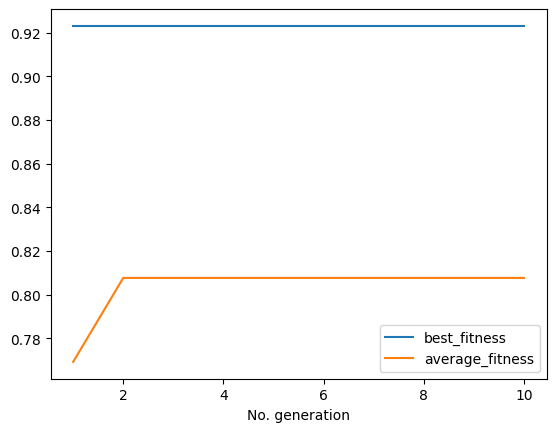

Initialize list of circuit ...
Start evol progress ...
Running at generation 1
          ┌───┐                                                                »
q_0: ─────┤ H ├────────────────────────────────────────────────────────────────»
          ├───┤                                ┌───┐                           »
q_1: ─────┤ X ├────────────────────────■───────┤ X ├───────────────────────────»
          └─┬─┘                        │       └─┬─┘           ┌──────────────┐»
q_2: ───────┼──────────────────────────┼─────────┼──────────■──┤ Rx(theta(4)) ├»
            │             ┌───┐        │         │          │  ├──────────────┤»
q_3: ───────■─────────────┤ H ├────────┼─────────■──────────┼──┤ Rx(theta(5)) ├»
     ┌──────────────┐┌────┴───┴─────┐  │  ┌──────────────┐  │  └──────────────┘»
q_4: ┤ Rx(theta(0)) ├┤ Rx(theta(1)) ├──┼──┤ Rx(theta(3)) ├──┼──────────────────»
     ├──────────────┤└──────────────┘┌─┴─┐└──────────────┘┌─┴─┐                »
q_5: ┤ Rx(theta(2)) ├─────────

[0.3846 0.6538 0.8846 0.6923]
Saving circuit ...
combined_qc1:  6
combined_qc2:  6
Số circuit 4
Saving circuit ...
Running at generation 2
                                                                    ┌───┐»
q_0: ──■────────────────────────────────────────────────────────────┤ X ├»
       │  ┌──────────────┐┌──────────────┐                          └─┬─┘»
q_1: ──┼──┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├────────────────────────────┼──»
       │  └──────────────┘└──────────────┘          ┌──────────────┐  │  »
q_2: ──┼─────────────────────────────────────────■──┤ Rx(theta[4]) ├──┼──»
       │                       ┌───┐      ┌───┐┌─┴─┐└──────────────┘  │  »
q_3: ──┼───────────────────────┤ X ├──────┤ X ├┤ X ├──────────────────■──»
       │  ┌──────────────┐     └─┬─┘      └─┬─┘└───┘                     »
q_4: ──┼──┤ Rx(theta[3]) ├───────┼──────────┼────────────────────────────»
     ┌─┴─┐├──────────────┤       │          │  ┌───┐                     »
q_5: ┤ X ├┤ Rx(theta[0]) ├───────■──

[0.8846 0.6923 0.6538 0.7308]
Saving circuit ...
combined_qc1:  6
combined_qc2:  6
Số circuit 4
Saving circuit ...
Running at generation 3
                                                                    ┌───┐»
q_0: ──■────────────────────────────────────────────────────────────┤ X ├»
       │  ┌──────────────┐┌──────────────┐                          └─┬─┘»
q_1: ──┼──┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├────────────────────────────┼──»
       │  └──────────────┘└──────────────┘          ┌──────────────┐  │  »
q_2: ──┼─────────────────────────────────────────■──┤ Rx(theta[4]) ├──┼──»
       │                       ┌───┐      ┌───┐┌─┴─┐└──────────────┘  │  »
q_3: ──┼───────────────────────┤ X ├──────┤ X ├┤ X ├──────────────────■──»
       │  ┌──────────────┐     └─┬─┘      └─┬─┘└───┘                     »
q_4: ──┼──┤ Rx(theta[3]) ├───────┼──────────┼────────────────────────────»
     ┌─┴─┐├──────────────┤       │          │  ┌───┐                     »
q_5: ┤ X ├┤ Rx(theta[0]) ├───────■──

[0.8846 0.7308 0.8846 0.7308]
Saving circuit ...
combined_qc1:  6
combined_qc2:  6
Số circuit 4
Saving circuit ...
Running at generation 4
                                                                    ┌───┐»
q_0: ──■────────────────────────────────────────────────────────────┤ X ├»
       │  ┌──────────────┐┌──────────────┐                          └─┬─┘»
q_1: ──┼──┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├────────────────────────────┼──»
       │  └──────────────┘└──────────────┘          ┌──────────────┐  │  »
q_2: ──┼─────────────────────────────────────────■──┤ Rx(theta[4]) ├──┼──»
       │                       ┌───┐      ┌───┐┌─┴─┐└──────────────┘  │  »
q_3: ──┼───────────────────────┤ X ├──────┤ X ├┤ X ├──────────────────■──»
       │  ┌──────────────┐     └─┬─┘      └─┬─┘└───┘                     »
q_4: ──┼──┤ Rx(theta[3]) ├───────┼──────────┼────────────────────────────»
     ┌─┴─┐├──────────────┤       │          │  ┌───┐                     »
q_5: ┤ X ├┤ Rx(theta[0]) ├───────■──

[0.8846 0.9231 0.8846 0.8846]
Saving circuit ...
combined_qc1:  6
combined_qc2:  6
Số circuit 4
Saving circuit ...
Running at generation 5
                                                                    ┌───┐»
q_0: ──■────────────────────────────────────────────────────────────┤ X ├»
       │  ┌──────────────┐┌──────────────┐                          └─┬─┘»
q_1: ──┼──┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├────────────────────────────┼──»
       │  └──────────────┘└──────────────┘          ┌──────────────┐  │  »
q_2: ──┼─────────────────────────────────────────■──┤ Rx(theta[4]) ├──┼──»
       │                       ┌───┐      ┌───┐┌─┴─┐└──────────────┘  │  »
q_3: ──┼───────────────────────┤ X ├──────┤ X ├┤ X ├──────────────────■──»
       │  ┌──────────────┐     └─┬─┘      └─┬─┘└───┘                     »
q_4: ──┼──┤ Rx(theta[3]) ├───────┼──────────┼────────────────────────────»
     ┌─┴─┐├──────────────┤       │          │  ┌───┐                     »
q_5: ┤ X ├┤ Rz(theta[0]) ├───────■──

[0.9231 0.8846 0.9231 0.8846]
Saving circuit ...
combined_qc1:  6
combined_qc2:  6
Số circuit 4
Saving circuit ...
Running at generation 6
                                                                    ┌───┐»
q_0: ──■────────────────────────────────────────────────────────────┤ X ├»
       │  ┌──────────────┐┌──────────────┐                          └─┬─┘»
q_1: ──┼──┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├────────────────────────────┼──»
       │  └──────────────┘└──────────────┘          ┌──────────────┐  │  »
q_2: ──┼─────────────────────────────────────────■──┤ Rx(theta[4]) ├──┼──»
       │                       ┌───┐      ┌───┐┌─┴─┐└──────────────┘  │  »
q_3: ──┼───────────────────────┤ X ├──────┤ X ├┤ X ├──────────────────■──»
       │  ┌──────────────┐     └─┬─┘      └─┬─┘└───┘                     »
q_4: ──┼──┤ Rx(theta[3]) ├───────┼──────────┼────────────────────────────»
     ┌─┴─┐├──────────────┤       │          │  ┌───┐                     »
q_5: ┤ X ├┤ Rz(theta[0]) ├───────■──

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  6
combined_qc2:  6
Số circuit 4
Saving circuit ...
Running at generation 7
                                                                    ┌───┐»
q_0: ──■────────────────────────────────────────────────────────────┤ X ├»
       │  ┌──────────────┐┌──────────────┐                          └─┬─┘»
q_1: ──┼──┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├────────────────────────────┼──»
       │  └──────────────┘└──────────────┘          ┌──────────────┐  │  »
q_2: ──┼─────────────────────────────────────────■──┤ Rx(theta[4]) ├──┼──»
       │                       ┌───┐      ┌───┐┌─┴─┐└──────────────┘  │  »
q_3: ──┼───────────────────────┤ X ├──────┤ X ├┤ X ├──────────────────■──»
       │  ┌──────────────┐     └─┬─┘      └─┬─┘└───┘                     »
q_4: ──┼──┤ Rx(theta[3]) ├───────┼──────────┼────────────────────────────»
     ┌─┴─┐├──────────────┤       │          │  ┌───┐                     »
q_5: ┤ X ├┤ Rz(theta[0]) ├───────■──

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  6
combined_qc2:  6
Số circuit 4
Saving circuit ...
Running at generation 8
                                                                    ┌───┐»
q_0: ──■────────────────────────────────────────────────────────────┤ X ├»
       │  ┌──────────────┐┌──────────────┐                          └─┬─┘»
q_1: ──┼──┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├────────────────────────────┼──»
       │  └──────────────┘└──────────────┘          ┌──────────────┐  │  »
q_2: ──┼─────────────────────────────────────────■──┤ Rx(theta[4]) ├──┼──»
       │                       ┌───┐      ┌───┐┌─┴─┐└──────────────┘  │  »
q_3: ──┼───────────────────────┤ X ├──────┤ X ├┤ X ├──────────────────■──»
       │  ┌──────────────┐     └─┬─┘      └─┬─┘└───┘                     »
q_4: ──┼──┤ Rx(theta[3]) ├───────┼──────────┼────────────────────────────»
     ┌─┴─┐├──────────────┤       │          │  ┌───┐                     »
q_5: ┤ X ├┤ Rz(theta[0]) ├───────■──

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  6
combined_qc2:  6
Số circuit 4
Saving circuit ...
Running at generation 9
                                                                    ┌───┐»
q_0: ──■────────────────────────────────────────────────────────────┤ X ├»
       │  ┌──────────────┐┌──────────────┐                          └─┬─┘»
q_1: ──┼──┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├────────────────────────────┼──»
       │  └──────────────┘└──────────────┘          ┌──────────────┐  │  »
q_2: ──┼─────────────────────────────────────────■──┤ Rx(theta[4]) ├──┼──»
       │                       ┌───┐      ┌───┐┌─┴─┐└──────────────┘  │  »
q_3: ──┼───────────────────────┤ X ├──────┤ X ├┤ X ├──────────────────■──»
       │  ┌──────────────┐     └─┬─┘      └─┬─┘└───┘                     »
q_4: ──┼──┤ Rx(theta[3]) ├───────┼──────────┼────────────────────────────»
     ┌─┴─┐├──────────────┤       │          │  ┌───┐                     »
q_5: ┤ X ├┤ Rz(theta[0]) ├───────■──

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  6
combined_qc2:  6
Số circuit 4
Saving circuit ...
Running at generation 10
                                                                    ┌───┐»
q_0: ──■────────────────────────────────────────────────────────────┤ X ├»
       │  ┌──────────────┐┌──────────────┐                          └─┬─┘»
q_1: ──┼──┤ Rx(theta[1]) ├┤ Rx(theta[2]) ├────────────────────────────┼──»
       │  └──────────────┘└──────────────┘          ┌──────────────┐  │  »
q_2: ──┼─────────────────────────────────────────■──┤ Rx(theta[4]) ├──┼──»
       │                       ┌───┐      ┌───┐┌─┴─┐└──────────────┘  │  »
q_3: ──┼───────────────────────┤ X ├──────┤ X ├┤ X ├──────────────────■──»
       │  ┌──────────────┐     └─┬─┘      └─┬─┘└───┘                     »
q_4: ──┼──┤ Rx(theta[3]) ├───────┼──────────┼────────────────────────────»
     ┌─┴─┐├──────────────┤       │          │  ┌───┐                     »
q_5: ┤ X ├┤ Rz(theta[0]) ├───────■─

Step: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  6
combined_qc2:  6
Số circuit 4
Saving circuit ...
End evol progress, best score ever: 0.9230769230769231


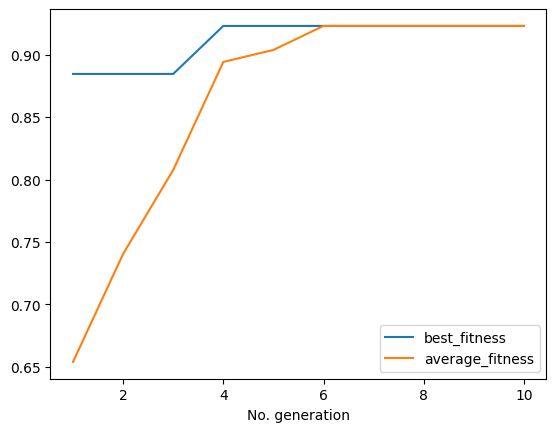

Initialize list of circuit ...
Start evol progress ...
Running at generation 1
                          ┌───┐                                      »
q_0: ───────■─────────────┤ X ├─────────────■───────────────■────────»
            │             └─┬─┘             │             ┌─┴─┐      »
q_1: ───────┼───────────────┼───────────────┼─────────────┤ X ├──────»
            │               │               │             └───┘      »
q_2: ───────┼───────────────┼───────────────┼────────────────────────»
          ┌─┴─┐             │               │                        »
q_3: ─────┤ X ├─────────────┼───────────────┼───────────────■────────»
          └───┘             │             ┌─┴─┐           ┌─┴─┐      »
q_4: ───────────────────────┼─────────────┤ X ├───────────┤ X ├──────»
                            │        ┌────┴───┴─────┐┌────┴───┴─────┐»
q_5: ───────────────────────■────────┤ Rz(theta(1)) ├┤ Rz(theta(6)) ├»
     ┌──────────────┐┌──────────────┐└──────────────┘└──────────────┘

[0.6538 0.6923 0.7692 0.5   ]
Saving circuit ...
combined_qc1:  7
combined_qc2:  7
Số circuit 4
Saving circuit ...
Running at generation 2
                                                                    »
q_0: ───────────────────────────────────────────────────────────────»
     ┌───┐     ┌───┐      ┌──────────────┐     ┌───┐                »
q_1: ┤ X ├─────┤ H ├──────┤ Rz(theta[4]) ├─────┤ H ├────────────────»
     └─┬─┘     ├───┤      ├──────────────┤     └───┘                »
q_2: ──┼───────┤ H ├──────┤ Rz(theta[6]) ├──────────────────────────»
       │  ┌────┴───┴─────┐└──────────────┘┌──────────────┐┌───┐┌───┐»
q_3: ──┼──┤ Rx(theta[0]) ├───────■────────┤ Ry(theta[1]) ├┤ X ├┤ X ├»
       │  └──────────────┘     ┌─┴─┐      └────┬───┬─────┘└─┬─┘└─┬─┘»
q_4: ──■───────────────────────┤ X ├───────────┤ X ├────────┼────┼──»
                               └───┘           └─┬─┘        │    │  »
q_5: ────────────────────────────────────────────┼──────────┼────■──»
               ┌───┐ 

[0.7692 0.6923 0.8462 0.5   ]
Saving circuit ...
combined_qc1:  7
combined_qc2:  7
Số circuit 4
Saving circuit ...
Running at generation 3
               ┌───┐                                               »
q_0: ──────────┤ H ├───────────────────────────────────────────────»
     ┌───┐     ├───┤      ┌───┐                                    »
q_1: ┤ X ├─────┤ H ├──────┤ H ├─────────────────────────────────■──»
     └─┬─┘┌────┴───┴─────┐└───┘                                 │  »
q_2: ──┼──┤ Rx(theta[4]) ├──────────────────────────────────────┼──»
       │  ├──────────────┤     ┌──────────────┐┌───┐┌───┐┌───┐┌─┴─┐»
q_3: ──┼──┤ Rx(theta[0]) ├──■──┤ Ry(theta[1]) ├┤ X ├┤ X ├┤ X ├┤ X ├»
       │  └──────────────┘┌─┴─┐└────┬───┬─────┘└─┬─┘└─┬─┘└─┬─┘└───┘»
q_4: ──■──────────────────┤ X ├─────┤ X ├────────┼────┼────■────■──»
                          └───┘     └─┬─┘        │    │  ┌───┐  │  »
q_5: ─────────────────────────────────┼──────────┼────■──┤ H ├──┼──»
               ┌───┐             

[0.8462 0.7692 0.7692 0.8462]
Saving circuit ...
combined_qc1:  7
combined_qc2:  7
Số circuit 4
Saving circuit ...
Running at generation 4
               ┌───┐                                               »
q_0: ──────────┤ H ├───────────────────────────────────────────────»
     ┌───┐     ├───┤      ┌───┐                                    »
q_1: ┤ X ├─────┤ H ├──────┤ H ├─────────────────────────────────■──»
     └─┬─┘┌────┴───┴─────┐└───┘                                 │  »
q_2: ──┼──┤ Rx(theta[4]) ├──────────────────────────────────────┼──»
       │  ├──────────────┤     ┌──────────────┐┌───┐┌───┐┌───┐┌─┴─┐»
q_3: ──┼──┤ Rx(theta[0]) ├──■──┤ Ry(theta[1]) ├┤ X ├┤ X ├┤ X ├┤ X ├»
       │  └──────────────┘┌─┴─┐└────┬───┬─────┘└─┬─┘└─┬─┘└─┬─┘└───┘»
q_4: ──■──────────────────┤ X ├─────┤ X ├────────┼────┼────■────■──»
                          └───┘     └─┬─┘        │    │  ┌───┐  │  »
q_5: ─────────────────────────────────┼──────────┼────■──┤ H ├──┼──»
               ┌───┐             

[0.8462 0.8462 0.8462 0.8462]
Saving circuit ...
combined_qc1:  7
combined_qc2:  7
Số circuit 4
Saving circuit ...
Running at generation 5
          ┌──────────────┐                                         »
q_0: ─────┤ Ry(theta[4]) ├─────────────────────────────────────────»
     ┌───┐└────┬───┬─────┘┌───┐                                    »
q_1: ┤ X ├─────┤ H ├──────┤ H ├─────────────────────────────────■──»
     └─┬─┘┌────┴───┴─────┐└───┘                                 │  »
q_2: ──┼──┤ Rx(theta[5]) ├──────────────────────────────────────┼──»
       │  ├──────────────┤     ┌──────────────┐┌───┐┌───┐┌───┐┌─┴─┐»
q_3: ──┼──┤ Rx(theta[0]) ├──■──┤ Ry(theta[1]) ├┤ X ├┤ X ├┤ X ├┤ X ├»
       │  └──────────────┘┌─┴─┐└────┬───┬─────┘└─┬─┘└─┬─┘└─┬─┘└───┘»
q_4: ──■──────────────────┤ X ├─────┤ X ├────────┼────┼────■────■──»
                          └───┘     └─┬─┘        │    │  ┌───┐  │  »
q_5: ─────────────────────────────────┼──────────┼────■──┤ H ├──┼──»
               ┌───┐             

[0.9231 0.8462 0.8462 0.8462]
Saving circuit ...
combined_qc1:  7
combined_qc2:  7
Số circuit 4
Saving circuit ...
Running at generation 6
          ┌──────────────┐                                         »
q_0: ─────┤ Ry(theta[4]) ├─────────────────────────────────────────»
     ┌───┐└────┬───┬─────┘┌───┐                                    »
q_1: ┤ X ├─────┤ H ├──────┤ H ├─────────────────────────────────■──»
     └─┬─┘┌────┴───┴─────┐└───┘                                 │  »
q_2: ──┼──┤ Rx(theta[5]) ├──────────────────────────────────────┼──»
       │  ├──────────────┤     ┌──────────────┐┌───┐┌───┐┌───┐┌─┴─┐»
q_3: ──┼──┤ Rx(theta[0]) ├──■──┤ Ry(theta[1]) ├┤ X ├┤ X ├┤ X ├┤ X ├»
       │  └──────────────┘┌─┴─┐└────┬───┬─────┘└─┬─┘└─┬─┘└─┬─┘└───┘»
q_4: ──■──────────────────┤ X ├─────┤ X ├────────┼────┼────■────■──»
                          └───┘     └─┬─┘        │    │  ┌───┐  │  »
q_5: ─────────────────────────────────┼──────────┼────■──┤ H ├──┼──»
               ┌───┐             

[0.9231 0.8462 0.8462 0.9231]
Saving circuit ...
combined_qc1:  7
combined_qc2:  7
Số circuit 4
Saving circuit ...
Running at generation 7
          ┌──────────────┐                                         »
q_0: ─────┤ Ry(theta[4]) ├─────────────────────────────────────────»
     ┌───┐└────┬───┬─────┘┌───┐                                    »
q_1: ┤ X ├─────┤ H ├──────┤ H ├─────────────────────────────────■──»
     └─┬─┘┌────┴───┴─────┐└───┘                                 │  »
q_2: ──┼──┤ Rx(theta[5]) ├──────────────────────────────────────┼──»
       │  ├──────────────┤     ┌──────────────┐┌───┐┌───┐┌───┐┌─┴─┐»
q_3: ──┼──┤ Rx(theta[0]) ├──■──┤ Ry(theta[1]) ├┤ X ├┤ X ├┤ X ├┤ X ├»
       │  └──────────────┘┌─┴─┐└────┬───┬─────┘└─┬─┘└─┬─┘└─┬─┘└───┘»
q_4: ──■──────────────────┤ X ├─────┤ X ├────────┼────┼────■────■──»
                          └───┘     └─┬─┘        │    │  ┌───┐  │  »
q_5: ─────────────────────────────────┼──────────┼────■──┤ H ├──┼──»
               ┌───┐             

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  7
combined_qc2:  7
Số circuit 4
Saving circuit ...
Running at generation 8
          ┌──────────────┐                                         »
q_0: ─────┤ Ry(theta[4]) ├─────────────────────────────────────────»
     ┌───┐└────┬───┬─────┘┌───┐                                    »
q_1: ┤ X ├─────┤ H ├──────┤ H ├─────────────────────────────────■──»
     └─┬─┘┌────┴───┴─────┐└───┘                                 │  »
q_2: ──┼──┤ Rx(theta[5]) ├──────────────────────────────────────┼──»
       │  ├──────────────┤     ┌──────────────┐┌───┐┌───┐┌───┐┌─┴─┐»
q_3: ──┼──┤ Rx(theta[0]) ├──■──┤ Ry(theta[1]) ├┤ X ├┤ X ├┤ X ├┤ X ├»
       │  └──────────────┘┌─┴─┐└────┬───┬─────┘└─┬─┘└─┬─┘└─┬─┘└───┘»
q_4: ──■──────────────────┤ X ├─────┤ X ├────────┼────┼────■────■──»
                          └───┘     └─┬─┘        │    │  ┌───┐  │  »
q_5: ─────────────────────────────────┼──────────┼────■──┤ H ├──┼──»
               ┌───┐             

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  7
combined_qc2:  7
Số circuit 4
Saving circuit ...
Running at generation 9
          ┌──────────────┐                                         »
q_0: ─────┤ Ry(theta[4]) ├─────────────────────────────────────────»
     ┌───┐└────┬───┬─────┘┌───┐                                    »
q_1: ┤ X ├─────┤ H ├──────┤ H ├─────────────────────────────────■──»
     └─┬─┘┌────┴───┴─────┐└───┘                                 │  »
q_2: ──┼──┤ Rx(theta[5]) ├──────────────────────────────────────┼──»
       │  ├──────────────┤     ┌──────────────┐┌───┐┌───┐┌───┐┌─┴─┐»
q_3: ──┼──┤ Rx(theta[0]) ├──■──┤ Ry(theta[1]) ├┤ X ├┤ X ├┤ X ├┤ X ├»
       │  └──────────────┘┌─┴─┐└────┬───┬─────┘└─┬─┘└─┬─┘└─┬─┘└───┘»
q_4: ──■──────────────────┤ X ├─────┤ X ├────────┼────┼────■────■──»
                          └───┘     └─┬─┘        │    │  ┌───┐  │  »
q_5: ─────────────────────────────────┼──────────┼────■──┤ H ├──┼──»
               ┌───┐             

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  7
combined_qc2:  7
Số circuit 4
Saving circuit ...
Running at generation 10
          ┌──────────────┐                                         »
q_0: ─────┤ Ry(theta[4]) ├─────────────────────────────────────────»
     ┌───┐└────┬───┬─────┘┌───┐                                    »
q_1: ┤ X ├─────┤ H ├──────┤ H ├─────────────────────────────────■──»
     └─┬─┘┌────┴───┴─────┐└───┘                                 │  »
q_2: ──┼──┤ Rx(theta[5]) ├──────────────────────────────────────┼──»
       │  ├──────────────┤     ┌──────────────┐┌───┐┌───┐┌───┐┌─┴─┐»
q_3: ──┼──┤ Rx(theta[0]) ├──■──┤ Ry(theta[1]) ├┤ X ├┤ X ├┤ X ├┤ X ├»
       │  └──────────────┘┌─┴─┐└────┬───┬─────┘└─┬─┘└─┬─┘└─┬─┘└───┘»
q_4: ──■──────────────────┤ X ├─────┤ X ├────────┼────┼────■────■──»
                          └───┘     └─┬─┘        │    │  ┌───┐  │  »
q_5: ─────────────────────────────────┼──────────┼────■──┤ H ├──┼──»
               ┌───┐            

Step: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

[0.9231 0.9231 0.9231 0.9231]
Saving circuit ...
combined_qc1:  7
combined_qc2:  7
Số circuit 4
Saving circuit ...
End evol progress, best score ever: 0.9230769230769231


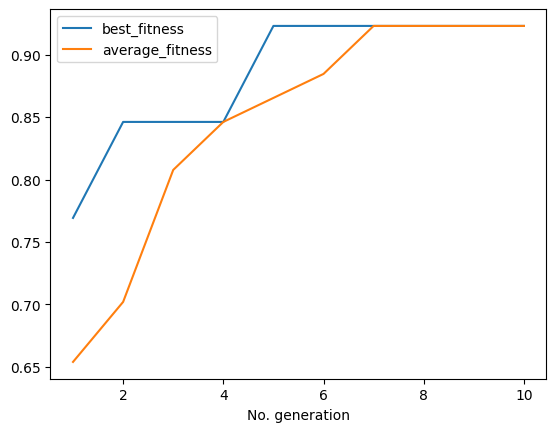

In [176]:
for i in range (3,8):
    auto_run(i) 


## ACCURACY

# WINE

In [177]:
x_values = list(range(2, 8))
yGA_values = []
yZ_values = []
yZZ_values = []
ySVM_values = []

In [178]:
print('GA')
for i in range(2,8):
    test = load_circuit(f'{i}qubits_train_qsvm_with_wine_2024-12-30/best_circuit')
    Xw_train, yw_train, Xw_test, yw_test = generate_wine(i)
    yGA_values.append(train_qsvm_with_wine(test))
    print('Accuracy:',train_qsvm_with_wine(test))
    
print('ZFeatureMap')
for i in range(2,8):
    test = ZFeatureMap(feature_dimension=i)
    Xw_train, yw_train, Xw_test, yw_test = generate_wine(i)
    yZ_values.append(train_qsvm_with_wine(test))
    print('Accuracy:',train_qsvm_with_wine(test))
    
print('ZZFeatureMap')
for i in range(2,8):
    test = ZZFeatureMap(feature_dimension=i)
    Xw_train, yw_train, Xw_test, yw_test = generate_wine(i)
    yZZ_values.append(train_qsvm_with_wine(test))
    print('Accuracy:',train_qsvm_with_wine(test))
    
    
print('SVM')
for i in range(2,8):
    ySVM_values.append(train_svm(i, generate_dataset=generate_wine))
    print('ACcuracy: ',train_svm(i, generate_dataset=generate_wine))



GA
Accuracy: 0.8846153846153846
Accuracy: 0.5769230769230769
Accuracy: 0.9230769230769231
Accuracy: 0.9230769230769231
Accuracy: 0.9230769230769231
Accuracy: 0.9230769230769231
ZFeatureMap
Accuracy: 0.5384615384615384
Accuracy: 0.5384615384615384
Accuracy: 0.5769230769230769
Accuracy: 0.6923076923076923
Accuracy: 0.6923076923076923
Accuracy: 0.8076923076923077
ZZFeatureMap
Accuracy: 0.5769230769230769
Accuracy: 0.5769230769230769
Accuracy: 0.5769230769230769
Accuracy: 0.6923076923076923
Accuracy: 0.5384615384615384
Accuracy: 0.5
SVM
ACcuracy:  0.9615384615384616
ACcuracy:  0.9230769230769231
ACcuracy:  0.9615384615384616
ACcuracy:  0.9615384615384616
ACcuracy:  1.0
ACcuracy:  1.0


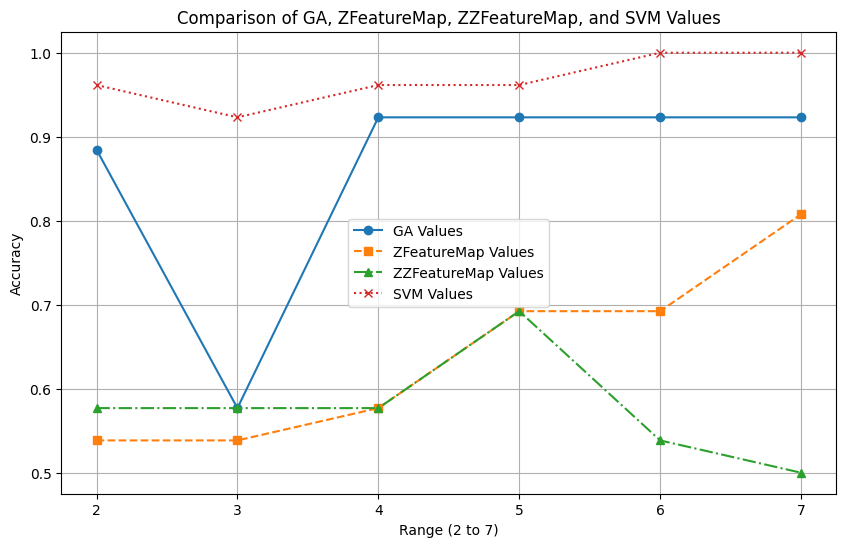

In [179]:
plt.figure(figsize=(10, 6))
plt.plot(x_values, yGA_values, marker='o', linestyle='-', label='GA Values')
plt.plot(x_values, yZ_values, marker='s', linestyle='--', label='ZFeatureMap Values')
plt.plot(x_values, yZZ_values, marker='^', linestyle='-.', label='ZZFeatureMap Values')
plt.plot(x_values, ySVM_values, marker='x', linestyle=':', label='SVM Values')
plt.title('Comparison of GA, ZFeatureMap, ZZFeatureMap, and SVM Values')
plt.xlabel('Range (2 to 7)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


# GermanCredit

In [87]:
x_values = list(range(2, 8))
yGA_values = []
yZ_values = []
yZZ_values = []
ySVM_values = []

In [89]:
print('GA')
for i in range(2,8):
    test = load_circuit(f'{i}qubits_train_qsvm_with_credit_2024-12-30/best_circuit')
    Xc_train, yc_train, Xc_test, yc_test = generate_credit(i)
    yGA_values.append(train_qsvm_with_credit(test))
    print('Accuracy:',train_qsvm_with_credit(test))
    
print('ZFeatureMap')
for i in range(2,8):
    test = ZFeatureMap(feature_dimension=i)
    Xw_train, yw_train, Xw_test, yw_test = generate_wine(i)
    yZ_values.append(train_qsvm_with_credit(test))
    print('Accuracy:',train_qsvm_with_credit(test))
    
print('ZZFeatureMap')
for i in range(2,8):
    test = ZZFeatureMap(feature_dimension=i)
    Xw_train, yw_train, Xw_test, yw_test = generate_wine(i)
    yZZ_values.append(train_qsvm_with_credit(test))
    print('Accuracy:',train_qsvm_with_credit(test))
    
    
print('SVM')
for i in range(2,8):
    ySVM_values.append(train_svm(i))
    print('ACcuracy: ',train_svm(i))



GA
Accuracy: 0.6966666666666667
Accuracy: 0.6966666666666667
Accuracy: 0.7166666666666667
Accuracy: 0.7133333333333334
Accuracy: 0.73
Accuracy: 0.74
ZFeatureMap
Accuracy: 0.69
Accuracy: 0.69
Accuracy: 0.69
Accuracy: 0.69
Accuracy: 0.69
Accuracy: 0.69
ZZFeatureMap
Accuracy: 0.6966666666666667
Accuracy: 0.6966666666666667
Accuracy: 0.6966666666666667
Accuracy: 0.6966666666666667
Accuracy: 0.6966666666666667
Accuracy: 0.6966666666666667
SVM
ACcuracy:  0.7133333333333334
ACcuracy:  0.7233333333333334
ACcuracy:  0.7033333333333334
ACcuracy:  0.72
ACcuracy:  0.7366666666666667
ACcuracy:  0.7633333333333333


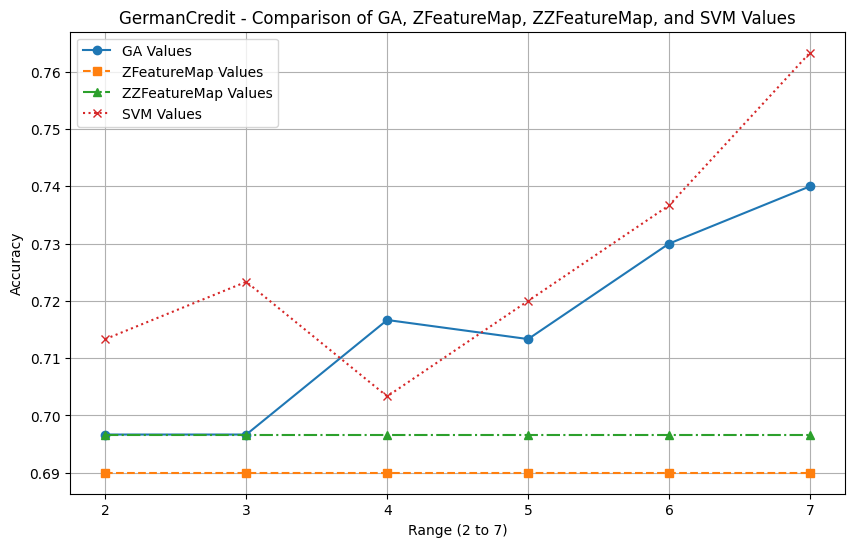

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(x_values, yGA_values, marker='o', linestyle='-', label='GA Values')
plt.plot(x_values, yZ_values, marker='s', linestyle='--', label='ZFeatureMap Values')
plt.plot(x_values, yZZ_values, marker='^', linestyle='-.', label='ZZFeatureMap Values')
plt.plot(x_values, ySVM_values, marker='x', linestyle=':', label='SVM Values')
plt.title('GermanCredit - Comparison of GA, ZFeatureMap, ZZFeatureMap, and SVM Values')
plt.xlabel('Range (2 to 7)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
